# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import os
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data
path = "./traffic-signs-data/"
training_file = os.path.join(path, "train.p")
testing_file = os.path.join(path, "test.p")

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


A general rule of thumb is to split the data by 70/30 for training and testing, consecutively.  Let's confirm the current setup...

In [3]:
print("Train / test split =", (round(1.0 - n_test/n_train, 2), round(n_test/n_train, 2)))

Train / test split = (0.68, 0.32)


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

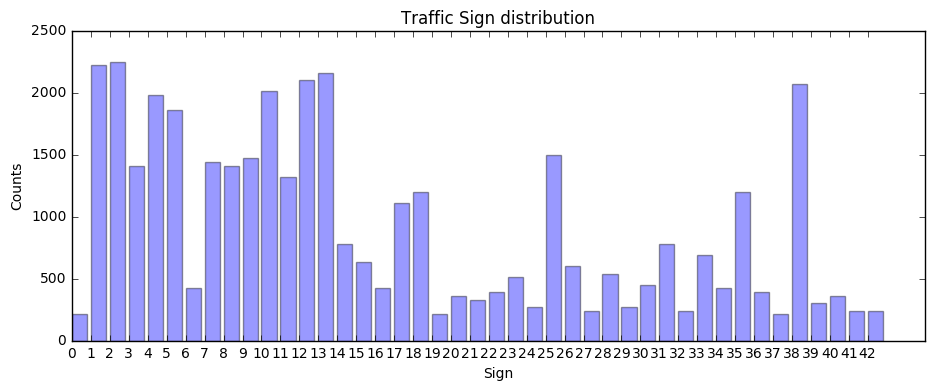

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# find labels
labels = np.unique(y_train)
counts = []

for i in labels:
    counts.append((y_train == i).sum())

# draw plots
plt.figure(figsize=(11,4))
plt.bar(labels, counts, alpha=0.4, width=0.8)
plt.xticks(labels, labels)
plt.ylabel('Counts')
plt.xlabel('Sign')
plt.title('Traffic Sign distribution')

plt.show()

Show the labels from both ends of the spectrum and the mean class count.

In [5]:
minindex = np.argmin(counts)
maxindex = np.argmax(counts)
print("Minimum class count = [{}] - {} samples".format(str(labels[minindex]), str(counts[minindex])))
print("Maximum class count = [{}] - {} samples".format(str(labels[maxindex]), str(counts[maxindex])))
print("Average class count = {} samples".format(round(np.mean(counts), 0)))

Minimum class count = [0] - 210 samples
Maximum class count = [2] - 2250 samples
Average class count = 912.0 samples


Now show the traffic signs and their fill distribution of the class having the highest frequency.  This determines which classes require more training data to get a proper target concept and how much to generate.

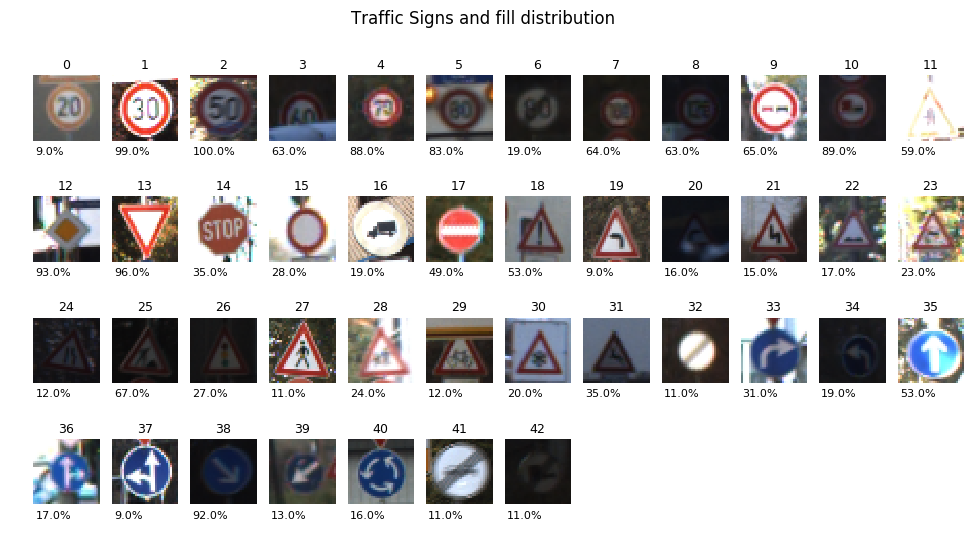

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec
from PIL import Image

samples = []
for i in labels:
    group = X_train[y_train == i]
    index = np.random.randint(low=0, high=len(group))
    img = Image.fromarray(group[index], "RGB" )
    samples.append(img)

num_rows = 4
num_cols = 12

fig = plt.figure(figsize=(12, 6))  # width, height in inches
max_count = np.max(counts)
sum_count = np.sum(counts)

for i in range(len(samples)):
    sub = fig.add_subplot(num_rows, num_cols, i + 1)
    sub.set_title(str(labels[i]), fontsize=9)
    sub.imshow(samples[i], interpolation='nearest')
    title = str(round(counts[i] / max_count, 2) * 100) + "%"
    sub.text(0.5,38, title, fontsize=8)
    sub.axis('off')

fig.suptitle("Traffic Signs and fill distribution",fontsize=12)

### Exploration Summary
As per the data exploration above it is shown that the distribution of speed signs, most notably the 50 km/h speed sign, has the largest count compared to other signs.  With the current data as it stands, any machine learning model will have a high bias towards this sign and the likelihood of correctly predicting a left turn sign for example will be 1/10th of that of the 50km/h sign.

In order to develop a strong model with a proper target concept, the distributions should be evenly stratified across all class labels.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# preprocessing params
# define number of color channels to use

color_channels = [0]

In [4]:
# Preprocessing infrastructure

class Processor():
    def __init__(self):
        return
    def process(self, features, labels):
        return features, labels

def preprocess(features, labels, processors):
    
    new_features = np.copy(features)
    new_labels = np.copy(labels)
    
    for processor in processors:
        new_features, new_labels = processor.process(new_features, new_labels)
    return new_features, new_labels

In [5]:
### Image channel preprocessor 
### Convert RGB to YUV channel and select channels

import cv2

class ImageProcessor(Processor):
    
    channels = [0,1,2]
    
    def __init__(self, channels):
        Processor.__init__(self)
        
        self.channels = channels
    
    def process(self, features, labels):
        if (len(features.shape) > 3):
            for i in range(len(features)):
                features[i] = cv2.cvtColor(features[i], cv2.COLOR_RGB2YUV)
        else:
            features = cv2.cvtColor(features, cv2.COLOR_RGB2YUV)
        
        if (len(features.shape) > 3):
            return features[:,:,:,self.channels],labels
        else:
            return features[:,:,self.channels],labels

In [6]:
### Sample Generator
### Generates new training data by adding random noise (mean centered)
### resulting in darker and lighter images after YUV processing

class Generator(Processor):
    def __init__(self, append = True, divergence = 0.1, max_count = None):
        Processor.__init__(self)
        
        self.append = append
        self.divergence = divergence
        self.max_count = max_count
    
    def process(self, features, labels):
        uniques = np.unique(labels)
        counts = []
        for i in uniques:
            counts.append((labels == i).sum())
        
        baseline = self.max_count or max(counts)
        
        new_features = np.empty((0, features.shape[1], features.shape[2], features.shape[3]))
        new_labels = np.empty(0)
        
        noise = self.divergence * np.mean(features)
        
        for i in range(len(uniques)):
            # determine counts (912 - 200) = 712 | 912 - 1200 = -288
            diff = (baseline - counts[i])
            
            # define sample set
            sample = (labels == i)
            
            if (self.append):
                for d in range(min(baseline, counts[i])):
                    index = np.random.randint(low=0, high=len(features[sample]))
                    x = features[sample][index]
                    y = labels[sample][index]

                    new_features = np.vstack((new_features, [x]))
                    new_labels = np.hstack((new_labels, [y]))
            
            if (diff > 0):
                print("Generating [label: {}] - {} samples".format(uniques[i], diff))
                for d in range(diff):
                    # choose index from sample set
                    index = np.random.randint(low=0, high=len(features[sample]))
                    # choose sample from sample set
                    x = features[sample][index]
                    # generate noise
                    rand = -noise + (np.random.rand() * ((noise - -noise)))
                    x_t = x + rand.astype(int)
                    x_t = np.maximum(np.minimum(x_t, 255), 0)

                    y_t = labels[sample][index]

                    new_features = np.vstack((new_features, [x_t]))
                    new_labels = np.hstack((new_labels, [y_t]))
        
        return new_features,new_labels

In [41]:
### Normalizer - Z-score

class Normalizer(Processor):
    def __init__(self, stat = None):
        Processor.__init__(self)
        self.stats = stat
    
    def process(self, features, labels):
        if (self.stats == None):
            self.stats = Stat(features)
        
        new_features = (features - self.stats.mean) / self.stats.std
        
        return new_features, labels
class Stat():
    def __init__(self, X, reverse = False):
        if (reverse):
            avg = np.mean(X, axis=0)
            std = np.std(X, axis=0)
            X = np.multiply(X, std) + avg
            X = (X - avg) / std
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        self.min = np.min(X, axis=0)
        self.max = np.max(X, axis=0)

#### Preprocess Images into YUV
First preprocess the images into a common format and select Y channel only.

In [12]:
processors = [ImageProcessor(color_channels)]
X_train_proc, y_train_proc = preprocess(X_train, y_train, processors=processors)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
To preprocess the features, I defined a modular preprocessing system. An RGB to YUV processor was used to first convert the image from RGB to YUV because of its similarity to the human visual system as well as the ability to use a single channel (Y channel).  By using the Y channel, which is the luminosity channel, it reduces model complexity without sacrificing model fidelity.  We can then generate data by introducing noise in the single luminance channel.

Then I generated data from existing data to evenly weight the training data across label spaces.  The method used for generating data was altering the luminosity to facilitate changes in lighting conditions.  Altering lighting conditions was chosen to reflect the dynamic driving conditions experienced in real-life.  Luminance alteration is made simple by the earlier conversion to the YUV colormap.

Normalisation was used using a z-score normalisation method, this allows enough divergence in the end feature range but allows gradient descent to have nice gradients and to find a decent optimum.

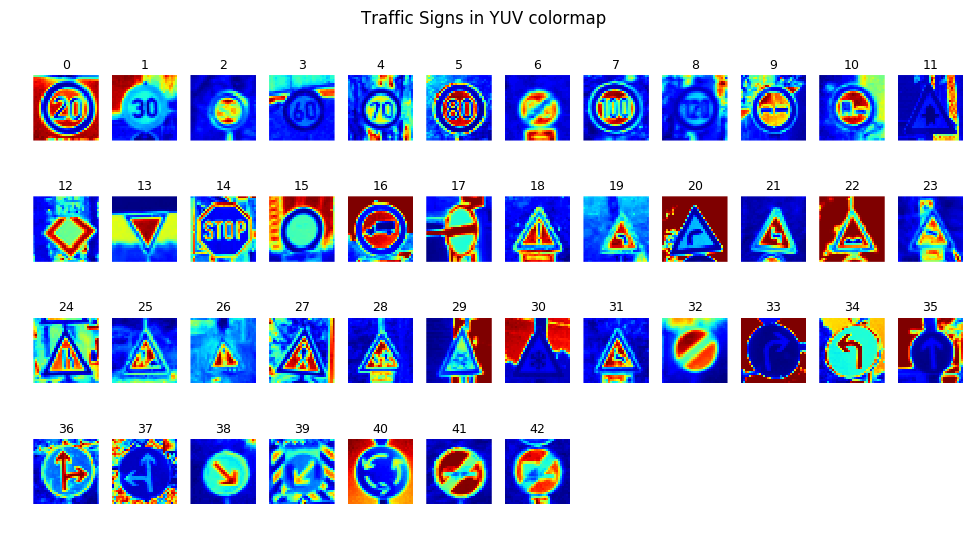

In [13]:
fig = plt.figure(figsize=(12, 6))  # width, height in inches

for i in range(len(labels)):
    group = X_train_proc[y_train == labels[i]]
    index = np.random.randint(low=0,high=len(group))
    
    # yuv magic process
    img = group[index]
    
    sub = fig.add_subplot(num_rows, num_cols, i + 1)
    sub.set_title(str(labels[i]), fontsize=9)
    sub.imshow(img[:,:,0], interpolation='none')
    sub.axis('off')

fig.suptitle("Traffic Signs in YUV colormap",fontsize=12)

In [14]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# use Generator for new data
processors = [Generator(append=True, max_count=int(np.mean(counts)))]
X_train_gen, y_train_gen = preprocess(X_train_proc, y_train_proc, processors=processors)

Generating [label: 0] - 701 samples
Generating [label: 6] - 491 samples
Generating [label: 14] - 131 samples
Generating [label: 15] - 281 samples
Generating [label: 16] - 491 samples
Generating [label: 19] - 701 samples
Generating [label: 20] - 551 samples
Generating [label: 21] - 581 samples
Generating [label: 22] - 521 samples
Generating [label: 23] - 401 samples
Generating [label: 24] - 641 samples
Generating [label: 26] - 311 samples
Generating [label: 27] - 671 samples
Generating [label: 28] - 371 samples
Generating [label: 29] - 641 samples
Generating [label: 30] - 461 samples
Generating [label: 31] - 131 samples
Generating [label: 32] - 671 samples
Generating [label: 33] - 222 samples
Generating [label: 34] - 491 samples
Generating [label: 36] - 521 samples
Generating [label: 37] - 701 samples
Generating [label: 39] - 611 samples
Generating [label: 40] - 551 samples
Generating [label: 41] - 671 samples
Generating [label: 42] - 671 samples


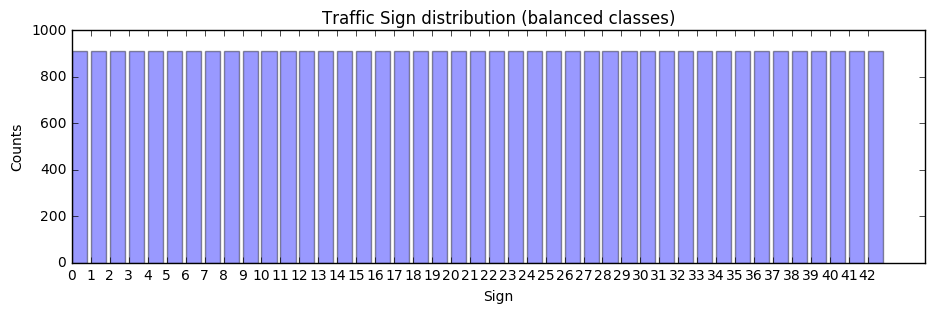

In [15]:
counts = []

for i in labels:
    counts.append((y_train_gen == i).sum())

# draw plots
plt.figure(figsize=(11,3))
plt.bar(labels, counts, alpha=0.4, width=0.8)
plt.xticks(labels, labels)
plt.ylabel('Counts')
plt.xlabel('Sign')
plt.title('Traffic Sign distribution (balanced classes)')

plt.show()

Generating [label: 0] - 2040 samples
Generating [label: 1] - 30 samples
Generating [label: 3] - 840 samples
Generating [label: 4] - 270 samples
Generating [label: 5] - 390 samples
Generating [label: 6] - 1830 samples
Generating [label: 7] - 810 samples
Generating [label: 8] - 840 samples
Generating [label: 9] - 780 samples
Generating [label: 10] - 240 samples
Generating [label: 11] - 930 samples
Generating [label: 12] - 150 samples
Generating [label: 13] - 90 samples
Generating [label: 14] - 1470 samples
Generating [label: 15] - 1620 samples
Generating [label: 16] - 1830 samples
Generating [label: 17] - 1140 samples
Generating [label: 18] - 1050 samples
Generating [label: 19] - 2040 samples
Generating [label: 20] - 1890 samples
Generating [label: 21] - 1920 samples
Generating [label: 22] - 1860 samples
Generating [label: 23] - 1740 samples
Generating [label: 24] - 1980 samples
Generating [label: 25] - 750 samples
Generating [label: 26] - 1650 samples
Generating [label: 27] - 2010 sampl

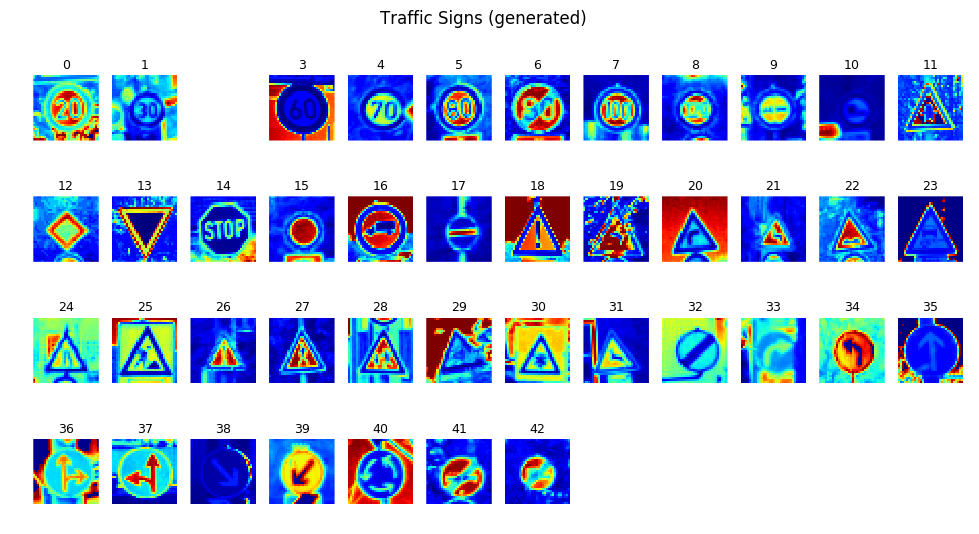

In [16]:
preprocessor=[ImageProcessor([0,1,2]), Generator(append=False)]
X_gen, y_gen = preprocess(X_train, y_train, processors=preprocessor)

fig = plt.figure(figsize=(12, 6))  # width, height in inches

for i in range(len(labels)):
    group = X_gen[y_gen == labels[i]]
    
    if (len(group) > 0):
        index = np.random.randint(low=0,high=len(group))

        img = group[index]

        sub = fig.add_subplot(num_rows, num_cols, i + 1)
        sub.set_title(str(labels[i]), fontsize=9)
        sub.imshow(img[:,:,0], interpolation='none')
        sub.axis('off')

fig.suptitle("Traffic Signs (generated)",fontsize=12)

#### Normalise Data
Normalise the training set data to ensure an optimal error slope during convergence.

In [17]:
normalizer = [Normalizer()]
X_train_norm, y_train_norm = preprocess(X_train_gen, y_train_gen, processors=normalizer)

#### Save / Restore Training Data Step
Save intermediate training data here and load from here in additional runs.

In [8]:
# define paths + files
import os

path = "./traffic-signs-data/"
training_proc_file = os.path.join(path, "train-proc.p")

In [19]:
# save intermediate output

data = { 'features': X_train_norm, 'labels': y_train_norm }

with open(training_proc_file, mode='wb') as f:
    train = pickle.dump(data, f)

In [9]:
# load presaved data
import pickle

with open(training_proc_file, mode='rb') as f:
    train = pickle.load(f)
    
    X_train_norm, y_train_norm = train['features'], train['labels']

#### Prepare Train/Valid sets
Using the newly augmented training set, take out a fraction for validation during training.  We should enough training data now to accomodate this without overfitting.

In [10]:
from sklearn.cross_validation import train_test_split

# Prepare input sets
# create validation set from modified train set

shape = X_train_norm.shape

print("Training set size: {}".format(shape))

X_train, X_valid, y_train, y_valid = train_test_split(X_train_norm, y_train_norm, test_size = 0.15, random_state=42)

print(" > After split:\t-\tTrain: {}\tValidation: {}\tTest: {}".format(len(X_train), len(X_valid), len(X_test)))

Training set size: (39173, 32, 32, 1)
 > After split:	-	Train: 33297	Validation: 5876	Test: 12630


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
Training data has been balanced across class labels to reduce label bias at prediction time. By stratifying the class label sample set sizes, the model will be forced to learn an accurate target concept. The additional data has been generated by adding random noise of +/- 10% to random samples, for each class label, and appending it to the training set.

To avoid test data bleeding into the model, the validation set was obtained from the modified training set, thus increasing the final test validation accuracy.  The final split of the data was approximately 65/10/25  (training/validation/test) after data augmentation.

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# helpers
def one_hot_encode(y, no_classes):
    one_hot = np.zeros([len(y), no_classes])
    for i in np.unique(y):
        one_hot[y == i, int(i)] = 1
    return one_hot

def shuffle(X,y):
    rand = np.argsort(np.random.rand(len(y)))
    return X[rand,:,:,:],y[rand]

# shuffle data prior to training
X_train, y_train = shuffle(X_train, y_train)

# one hot encode labels
Y_train = one_hot_encode(y_train, n_classes)
Y_test = one_hot_encode(y_test, n_classes)
Y_valid = one_hot_encode(y_valid, n_classes)

assert Y_train[0, int(y_train[0])] == 1.
assert np.sum(Y_train[0, :]) == 1
assert Y_train[1, int(y_train[1])] == 1.
assert np.sum(Y_train[1, :]) == 1

In [12]:
# Imports

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import tensorflow.contrib.slim as slim

In [13]:
# Shared components

def get_input_size(input):
    return input.get_shape().as_list()

# creates a TF weight variable
def get_weight(shape, name=None):
    randw = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(randw, name=name)

# creates a TF bias variable
def get_bias(size, name=None):
    return tf.Variable(tf.zeros(size, name=name))

def BatchNorm(input, is_training = None):
    #out_channels = get_input_size(input)[3:][0]
    
    #mean, var = tf.nn.moments(input, axes=[0,1,2])
    #beta = get_bias([out_channels], name="beta")
    #gamma = get_weight([out_channels], name="gamma")
    
    # batch norm
    #batch_norm = tf.nn.batch_norm_with_global_normalization(input, mean, var, beta, 
    #                                                        gamma, 0.001, scale_after_normalization=True)
    batch_norm = tf.contrib.layers.batch_norm(input, scale=True, 
                                              is_training=is_training, 
                                              updates_collections=None)
    
    return batch_norm

# BC layer
def BatchConvolution(input, input_dim, output_dim, kernel_dim = 2, dropout = 0.5, is_training = None):
    bc = BatchNorm(input, is_training = is_training)
    
    bc_relu = ReLU(bc)
    bc_conv = Convolution(bc_relu, input_dim, output_dim, kernel_dim=kernel_dim, stride_dim=1)
    output = Dropout(bc_conv, prob=dropout)
    
    return output

def Convolution(input, input_dim, output_dim, kernel_dim = 2, stride_dim = 2, padding='SAME', add_bias = False):
    filter_shape = [kernel_dim, kernel_dim, input_dim, output_dim]
    filter = get_weight(filter_shape)
    stride_shape = [1, stride_dim, stride_dim, 1]
    print(" - Conv: Input = [{}], Filter = [{}], Stride = [{}]".format(input.get_shape(), filter.get_shape(), stride_shape))
    conv = tf.nn.conv2d(input, filter=filter, strides=stride_shape, padding=padding)
    
    if add_bias:
        return conv + get_bias([output_dim])
    
    return conv

def AvgPool(input, kernel_dim = 2, stride_dim = 2, padding = 'SAME'):
    kernel = [1, kernel_dim, kernel_dim, 1]
    stride = [1, stride_dim, stride_dim, 1]
    return tf.nn.avg_pool(input, ksize=kernel, strides=stride, padding=padding)

def MaxPool(input, kernel_dim = 2, stride_dim = 2, padding = 'SAME'):
    kernel = [1, kernel_dim, kernel_dim, 1]
    stride = [1, stride_dim, stride_dim, 1]
    return tf.nn.max_pool(input, ksize=kernel, strides=stride, padding=padding)

def ReLU(input):
    return tf.nn.relu(input)

def Dropout(input, prob = 0.5):
    return tf.nn.dropout(input, prob)

def Softmax(input):
    return tf.nn.softmax(input)

def FullyConnected(input, output_dim, as_flat=False):
    
    if (as_flat):
        input_layer = flatten(input)
    else:
        input_layer = input
    
    shape = (get_input_size(input)[1:][0], output_dim)
    
    fc1_W = get_weight(shape)
    fc1_b = get_bias([shape[1]])
    fc1_h = tf.matmul(input_layer, fc1_W) + fc1_b
    
    return fc1_h

def DenseBlock(input, num_layers, input_dim, growth, dropout = 0.5, is_training = True):
    output = input
    size = input_dim
    
    for i in range(num_layers):
        bc = BatchConvolution(output, size, growth, kernel_dim=3, dropout=dropout, is_training=train)
        output = tf.concat(3, (output, bc))
        size += growth
    
    return output, size


In [14]:
# DenseNet Architecture
# Adapted from https://github.com/LaurentMazare/deep-models/

def DenseNet(X, input_dim, output_dim, depth = 40, k = 12, dropout = None, train = None):
    layers = int((depth - 4) / 3)
    input_depth = get_input_size(X)[3:][0]
    
    # First Convolution: Input = 32x32x1 => Output =>
    conv_1 = Convolution(X, input_dim, 16, kernel_dim=3, stride_dim=1, padding='SAME')
    print("Conv Layer: [{}]".format(conv_1.get_shape()))
    
    # Block Layer 1
    block_1, features = DenseBlock(conv_1, layers, 16, k, dropout=dropout, is_training=train)
    print("Block Layer: [{}] => size: {}".format(block_1.get_shape(), features))
    
    # Batch Convolutional Layer
    bc_1 = BatchConvolution(block_1, features, features, kernel_dim=1, dropout=dropout, is_training=train)
    print("Batch Conv Layer: [{}]".format(bc_1.get_shape()))
    # Average Pooling
    pool_1 = AvgPool(bc_1, kernel_dim=2, stride_dim=2, padding='VALID')
    print("Average Pool Layer: [{}]".format(pool_1.get_shape()))
    
    # Block Layer 2
    block_2, features = DenseBlock(pool_1, layers, features, k, dropout=dropout, is_training=train)
    print("Block Layer: [{}] => size: {}".format(block_2.get_shape(), features))
    # Batch Convolutional Layer
    bc_2 = BatchConvolution(block_2, features, features, kernel_dim=1, dropout=dropout, is_training=train)
    print("Batch Conv Layer: [{}]".format(bc_2.get_shape()))
    # Average Pooling
    pool_2 = AvgPool(bc_2, kernel_dim=2, stride_dim=2, padding='VALID')
    print("Average Pool Layer: [{}]".format(pool_2.get_shape()))
    
    # Block Layer 3
    block_3, features = DenseBlock(pool_2, layers, features, k, dropout=dropout, is_training=train)
    print("Block Layer: [{}] => size: {}".format(block_3.get_shape(), features))
    
    # Batch Normalisation Layer
    bn_norm = BatchNorm(block_3, is_training=train)
    print("Batch Normalization Layer: [{}]".format(bn_norm.get_shape()))
    # ReLU Activation
    bn_relu = ReLU(bn_norm)
    print("ReLU Activation Layer: [{}]".format(bn_relu.get_shape()))
    # Final Average Pooling Layer
    pool_3 = AvgPool(bn_relu, kernel_dim=8, stride_dim=8, padding='VALID')
    print("Average Pool Layer: [{}]".format(pool_3.get_shape()))
    
    final_dim = features
    
    flattened = tf.reshape(pool_3, [-1, final_dim])
    
    # FC Layer
    fc = FullyConnected(flattened, output_dim)
    print("FC Layer: [{}]".format(fc.get_shape()))
    
    # Softmax output
    output = Softmax(fc)
    print("Softmax Layer: [{}]".format(output.get_shape()))
    
    return output

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
The model architecture I'm using is "DenseNet", a type based on Residual Networks (ResNets), by Huang et al (see https://arxiv.org/abs/1608.06993).  DenseNets are an improvement over typical ResNets due to their comparable accuracy whilst having fewer trainable parameters, which makes them ideal for architecting deeper networks.  Because of their architecture they are easier to train, and like other residual networks have an innate ability to learn higher order features.

Each layer is built using the same linear function and activations seen in ConvNets but they are combined with an identity or "shortcut" function which preserves the input over many layers.  This preservation of input is achieved through blocks which allow inputs to flow through successive layers.  It is these shortcut connections that reduce the trainable parameters and result in a more compact but higher fidelity network.

##### The architecture of my model is as follows:

**Input Layer:** [32, 32, 1]

**Convolution:** Input = [32, 32, 1], Filter = 3, Stride = 1, Padding = SAME, Output = [32, 32, 16]

**Dense Block:** Input = [32, 32, 16].  Output = [32, 32, 160], Padding = SAME
 - Conv: Input = [32, 32, 16], Filter = 3x3, Stride = 1
 - Conv: Input = [32, 32, 28], Filter = 3x3, Stride = 1
 - Conv: Input = [32, 32, 40], Filter = 3x3, Stride = 1
 - Conv: Input = [32, 32, 52], Filter = 3x3, Stride = 1
 - Conv: Input = [32, 32, 64], Filter = 3x3, Stride = 1
 - Conv: Input = [32, 32, 76], Filter = 3x3, Stride = 1
 - Conv: Input = [32, 32, 88], Filter = 3x3, Stride = 1
 - Conv: Input = [32, 32, 100], Filter = 3x3, Stride = 1
 - Conv: Input = [32, 32, 112], Filter = 3x3, Stride = 1
 - Conv: Input = [32, 32, 124], Filter = 3x3, Stride = 1
 - Conv: Input = [32, 32, 136], Filter = 3x3, Stride = 1
 - Conv: Input = [32, 32, 148], Filter = 3x3, Stride = 1

**Batched Convolution:** Input = [32, 32, 160], Filter = 1x1, Stride = 1
**Average Pool Layer:** Input = [32, 32, 160], Filter = 2x2, Stride = 2, Padding = VALID, Output = [16, 16, 160]

**Dense Block:** Input = [16, 16, 160], Output = [16, 16, 304], Padding = SAME
 - Conv: Input = [16, 16, 160], Filter = 3x3, Stride = 1
 - Conv: Input = [16, 16, 172], Filter = 3x3, Stride = 1
 - Conv: Input = [16, 16, 184], Filter = 3x3, Stride = 1
 - Conv: Input = [16, 16, 196], Filter = 3x3, Stride = 1
 - Conv: Input = [16, 16, 208], Filter = 3x3, Stride = 1
 - Conv: Input = [16, 16, 220], Filter = 3x3, Stride = 1
 - Conv: Input = [16, 16, 232], Filter = 3x3, Stride = 1
 - Conv: Input = [16, 16, 244], Filter = 3x3, Stride = 1
 - Conv: Input = [16, 16, 256], Filter = 3x3, Stride = 1
 - Conv: Input = [16, 16, 268], Filter = 3x3, Stride = 1
 - Conv: Input = [16, 16, 280], Filter = 3x3, Stride = 1
 - Conv: Input = [16, 16, 292], Filter = 3x3, Stride = 1

**Batched Convolution:** Input = [16, 16, 304], Filter = 1, Stride = 1
**Average Pool Layer:** [16, 16, 304], Filter = 2x2, Stride = 2, Padding = VALID, Output = [8, 8, 304]

**Dense Block:** Input = [8, 8, 304], Output = [8, 8, 448], Padding = SAME
 - Conv: Input = [8, 8, 304], Filter = 3x3, Stride = 1
 - Conv: Input = [8, 8, 316], Filter = 3x3, Stride = 1
 - Conv: Input = [8, 8, 328], Filter = 3x3, Stride = 1
 - Conv: Input = [8, 8, 340], Filter = 3x3, Stride = 1
 - Conv: Input = [8, 8, 352], Filter = 3x3, Stride = 1
 - Conv: Input = [8, 8, 364], Filter = 3x3, Stride = 1
 - Conv: Input = [8, 8, 376], Filter = 3x3, Stride = 1
 - Conv: Input = [8, 8, 388], Filter = 3x3, Stride = 1
 - Conv: Input = [8, 8, 400], Filter = 3x3, Stride = 1
 - Conv: Input = [8, 8, 412], Filter = 3x3, Stride = 1
 - Conv: Input = [8, 8, 424], Filter = 3x3, Stride = 1
 - Conv: Input = [8, 8, 436], Filter = 3x3, Stride = 1

**Batch Normalization Layer:** Input = [8, 8, 448], Output = [8, 8, 448]
**ReLU Activation Layer**

**Average Pool Layer:** Input = [8, 8, 448], Output = [1, 1, 448]

**Fully Connected Layer:** Input = [448], Output = [43]

**Softmax Layer:** Input = [43], Output = [43]


**Total layers = 46**
 

In [15]:
# shape params
num_classes = n_classes
img_width = image_shape[0]
img_height = image_shape[1]
num_channels = X_train_norm.shape[3]

# setup TF inputs
X = tf.placeholder(tf.float32, (None, img_width, img_height, num_channels), name="X")
Y = tf.placeholder(tf.float32, (None, num_classes), name="Y")
alpha = tf.placeholder(tf.float32, [], name="alpha")
dropout = tf.placeholder(tf.float32, name="dropout")
train = tf.placeholder(tf.bool, shape=[], name="train")

In [16]:
# init model

net = DenseNet(X, num_channels, num_classes, depth=40, dropout=dropout, train=train)

 - Conv: Input = [(?, 32, 32, 1)], Filter = [(3, 3, 1, 16)], Stride = [[1, 1, 1, 1]]
Conv Layer: [(?, 32, 32, 16)]
 - Conv: Input = [(?, 32, 32, 16)], Filter = [(3, 3, 16, 12)], Stride = [[1, 1, 1, 1]]
 - Conv: Input = [(?, 32, 32, 28)], Filter = [(3, 3, 28, 12)], Stride = [[1, 1, 1, 1]]
 - Conv: Input = [(?, 32, 32, 40)], Filter = [(3, 3, 40, 12)], Stride = [[1, 1, 1, 1]]
 - Conv: Input = [(?, 32, 32, 52)], Filter = [(3, 3, 52, 12)], Stride = [[1, 1, 1, 1]]
 - Conv: Input = [(?, 32, 32, 64)], Filter = [(3, 3, 64, 12)], Stride = [[1, 1, 1, 1]]
 - Conv: Input = [(?, 32, 32, 76)], Filter = [(3, 3, 76, 12)], Stride = [[1, 1, 1, 1]]
 - Conv: Input = [(?, 32, 32, 88)], Filter = [(3, 3, 88, 12)], Stride = [[1, 1, 1, 1]]
 - Conv: Input = [(?, 32, 32, 100)], Filter = [(3, 3, 100, 12)], Stride = [[1, 1, 1, 1]]
 - Conv: Input = [(?, 32, 32, 112)], Filter = [(3, 3, 112, 12)], Stride = [[1, 1, 1, 1]]
 - Conv: Input = [(?, 32, 32, 124)], Filter = [(3, 3, 124, 12)], Stride = [[1, 1, 1, 1]]
 - Conv: 

In [17]:
# Print number of trainable params (http://stackoverflow.com/a/39936930/5491223)

def count_number_trainable_params():
    '''
    Counts the number of trainable variables.
    '''
    tot_nb_params = 0
    for trainable_variable in tf.trainable_variables():
        shape = trainable_variable.get_shape() # e.g [D,F] or [W,H,C]
        current_nb_params = get_nb_params_shape(shape)
        tot_nb_params = tot_nb_params + current_nb_params
    return tot_nb_params

def get_nb_params_shape(shape):
    '''
    Computes the total number of params for a given shap.
    Works for any number of shapes etc [D,F] or [W,H,C] computes D*F and W*H*C.
    '''
    nb_params = 1
    for dim in shape:
        nb_params = nb_params*int(dim)
    return nb_params

train_params = count_number_trainable_params()
print("Model: DenseNet")
print("Total number of trainable parameters: {}M".format(round(train_params/1e+6, 2)))

Model: DenseNet
Total number of trainable parameters: 1.03M


In [24]:
# Training params
learning_rate = 0.001
momentum = 0.9
epsilon = 1e-12
weight_decay = 1e-4
drop_out = 0.6
training = True

BATCH_SIZE = 128
EPOCHS = 10
directory = os.path.join("./model/", "DenseNet")

# Sizes
train_size = X_train_norm.shape[0]
valid_size = X_valid.shape[0]
test_size = X_test.shape[0]

In [49]:
### Model evaluation
correct_prediction = tf.equal(tf.argmax(net, 1), tf.argmax(Y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        
        feed_dict={ X: batch_x, Y: batch_y, alpha: learning_rate, dropout: 1., train: False}
        accuracy = sess.run(accuracy_operation, feed_dict=feed_dict)
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [20]:
# Model optimisation
cross_entropy = -tf.reduce_sum(Y * tf.log(net + epsilon))
#l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in tf.trainable_variables()])
#loss_operation = tf.reduce_mean(cross_entropy# + l2_loss * weight_decay#)
loss_operation = tf.reduce_mean(cross_entropy)
                                
# Optimiser
#optimizer = tf.train.MomentumOptimizer(alpha, momentum, use_nesterov=True)
optimizer = tf.train.AdamOptimizer(alpha)
training_op = optimizer.minimize(loss_operation)

In [51]:
### Train your model here.
### Feel free to use as many code cells as needed.

saver = tf.train.Saver()

# check model dir exists
if not os.path.exists(directory):
    os.makedirs(directory)
    
model_path = os.path.join(directory, 'ConvNet')

with tf.Session() as sess:
    # init op
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    # TF RESTORE BROKEN
    # restore from checkpoint (if available)
    checkpoint = tf.train.latest_checkpoint(directory)
    if checkpoint:
        print("Restoring from checkpoint...", checkpoint)
        saver.restore(sess, checkpoint)
        print("Done.")
    else:
        print("Couldn't find checkpoint to restore from. Starting over.")
    
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # shuffle on iter
        X_train, Y_train = shuffle(X_train, Y_train)
        
        print("EPOCH {} ...".format(i+1))
        
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_train[offset:offset+BATCH_SIZE], Y_train[offset:offset+BATCH_SIZE]
            
            feed_dict={ X: batch_x, Y: batch_y, alpha: learning_rate, dropout: drop_out, train: training }
            
            sess.run(training_op, feed_dict=feed_dict)
            
            if offset % 2048 == 0:
                print(" - batch: {}:{}".format(offset, offset+BATCH_SIZE))
        
        validation_accuracy = evaluate(X_valid, Y_valid)
        
        saver.save(sess, model_path, global_step=i)
        print ("Checkpoint: [{}]".format(i))
        
        print("Accuracy:\tValidation: {:.3f}".format(validation_accuracy))
        if (validation_accuracy >= 0.92):
            print("Stop point reached. Quitting...")
            break
        print()
    
    print("Model saved")

Restoring from checkpoint... ./model/DenseNet\ConvNet-8
Done.
Training...

EPOCH 1 ...
 - batch: 0:128
 - batch: 2048:2176
 - batch: 4096:4224
 - batch: 6144:6272
 - batch: 8192:8320
 - batch: 10240:10368
 - batch: 12288:12416
 - batch: 14336:14464
 - batch: 16384:16512
 - batch: 18432:18560
 - batch: 20480:20608
 - batch: 22528:22656
 - batch: 24576:24704
 - batch: 26624:26752
 - batch: 28672:28800
 - batch: 30720:30848
 - batch: 32768:32896
Checkpoint: [0]
Accuracy:	Validation: 0.981
Stop point reached. Quitting...
Model saved


In [ ]:
def get_accuracy(X_data, Y_data):
    saver = tf.train.Saver()
    accuracy = 0
    
    with tf.Session() as sess:
        # init vars
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        
        checkpoint = tf.train.latest_checkpoint(directory)
        if checkpoint:
            print("Restoring from checkpoint...", checkpoint)
            saver.restore(sess, checkpoint)
            print("Done.")
        else:
            print("Couldn't find checkpoint to restore from.")

        accuracy = evaluate(X_data, Y_data)
    return accuracy

In [56]:
test_accuracy = get_accuracy(X_valid, Y_valid)
print("Final Validation Accuracy = {:.3f}".format(test_accuracy))

Restoring from checkpoint... ./model/DenseNet\ConvNet-0
Done.
Final Validation Accuracy = 0.981


In [121]:
# Load test data (in case it's not loaded

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_test, y_test = test['features'], test['labels']

In [122]:
# preprocess test samples
normalizer = Normalizer()
X_test, y_test = preprocess(X_test, y_test, processors=[ImageProcessor(color_channels)])
X_test, y_test = preprocess(X_test, y_test, processors=[normalizer])

Y_test = one_hot_encode(y_test, num_classes)

In [123]:
# predict on test data
test_accuracy = get_accuracy(X_test, Y_test)
print("Test Accuracy = {:.3f}".format(test_accuracy))

Restoring from checkpoint... ./model/DenseNet\ConvNet-0
Done.
Test Accuracy = 0.897


In [63]:
# check training data accuracy to see overfitting
test_accuracy = evaluate(X_train, Y_train)
print("Train Accuracy = {:.3f}".format(test_accuracy))

Restoring from checkpoint... ./model/DenseNet\ConvNet-0
Done.
Train Accuracy = 0.980


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
A batch size of 128 examples were used in training which is approximately 0.5% of the training data.  Because of the smaller batches used, I chose the Adam optimiser with a cross entropy loss function.  RMSProp would have been suitable here also, as it is well defined in mini-batch learning but generally Adam outpeforms RMSProp in late stage training.  The Adam optimiser employs per-parameter weight updates which accelerates gradient descent and avoids spurious minima.  It also mitigates any potential issues of "catastrophic forgetting" common in gradient descent based optimisation algorithms trained on small batch sizes.  In this setting the default optimisation hyperparameters have been used without need for modification.

The learning rate was left static at 0.001 as experimentation showed that a learning rate higher than this caused the loss to deviate from the objective, probably due to the complexity induced with random noise during data augmentation.

Dropout was set to 0.8 for the hidden layers (dense blocks) for the first 20 epochs and was reduced to 0.6 for the last 8 epochs to prevent overfitting.

In total the model was trained for 28 epochs, stopping when the model had a high enough accuracy on the validation set.  The model could have been trained longer with time permitting, but at 2.5 hours per epoch, time was of the essence.

The total number of trainable parameters contained within the model was 1.03 million.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
For this solution, I used my intuition as well as research on deep learning models for image recognition tasks.  Originally I had implemented Residual Networks but later research found that DenseNets outperform ResNets with fewer training parameters.  I also found that LeNets and ResNets were not able to learn as effectively as the DenseNet architecture.  DenseNets have shown an improvement over standard ConvNets as well as older tried and true variants of ConvNets such as LeNet, GoogleLeNet, VGG Nets, etc. on current performance evaluation datasets.

Initial experiments showed that the LeNet model was not suited to the task, which I postulate was due to the data augmentation and the reduced dimensionality with using only one colour channel.  This made the decision to train a network with greater complexity more concrete.  After a slow start with ResNet training I reevaluated my approach and searched current literature and found the DenseNet architecture.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [124]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

def plot(dir, files, no_rows, no_cols):
    fig = plt.figure(1, (10., 4.))
    i = 0
    
    for file in files:
        image = mpimg.imread(os.path.join(dir, file))
        sub = fig.add_subplot(no_rows, no_cols, i + 1)
        sub.imshow(image)
        sub.set_title(file, fontsize=9)
        sub.axis("off")
        i += 1

    plt.show()

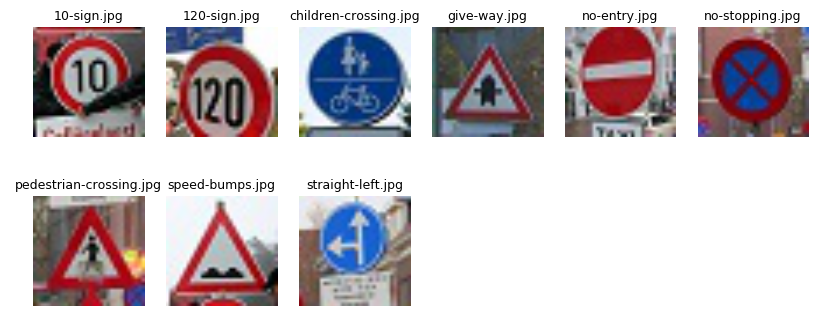

In [125]:
test_dir = "test_images/"
test_files = os.listdir(test_dir)

plot(test_dir, test_files, 2, 6)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
The five candidates are: "no-entry", "straight-left", "pedestrian-crossing", "children-crossing", "120-sign".  These images, are partially skewed or hidden such as in the case of the pedestrian sign.  From initial observations there were few skewed images in the original dataset which makes testing these types of images interesting. I've also included the children crossing sign as it combines two signs, bike (29) and children (28) crossing, which will be interesting to the see the output of.

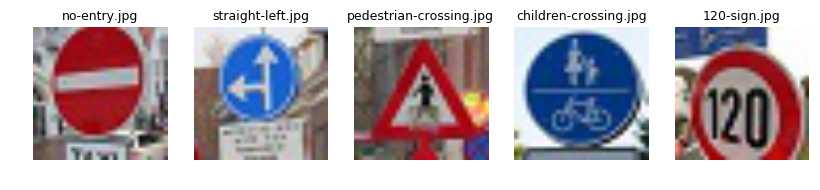

In [126]:
pred_files = [test_files[4], test_files[8], test_files[6], test_files[2], test_files[1]]
actual_files = [17, 37, 27, 28, 8]
plot(test_dir, pred_files, 1, 5)

In [127]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
pred_test = []

for file in pred_files:
    img = mpimg.imread(os.path.join(test_dir, file))
    pred_test.append(img)

argmax_op = tf.argmax(net, 1)

# prepare inputs
X_test_new = np.array(pred_test)
y_test_new = np.array(actual_files)
# preprocess + normalise inputs
X_test_new, y_test_new = preprocess(X_test_new, y_test_new, processors=[ImageProcessor(color_channels)])
X_test_new, y_test_new = preprocess(X_test_new, y_test_new, processors=[normalizer])

# setup batches and one-hot encode
batch_x = X_test_new
batch_y = one_hot_encode(y_test_new, num_classes)

softmax_output = None

with tf.Session() as sess:
    # init vars
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    checkpoint = tf.train.latest_checkpoint(directory)
    if checkpoint:
        print("Restoring from checkpoint...", checkpoint)
        saver.restore(sess, checkpoint)
        print("Done.")
    else:
        print("Couldn't find checkpoint to restore from.")
    
    feed_dict={ X: batch_x, Y: batch_y, alpha: learning_rate, dropout: 1., train: False }
    
    args = sess.run(argmax_op, feed_dict=feed_dict)
    softmax_output = sess.run(net, feed_dict=feed_dict)
    
    test_acc = evaluate(batch_x, batch_y)
    
    print("Predictions: \nOutput: {}\nActual: {}".format(args, actual_files))
    print("Accuracy = {:.3f}".format(test_acc))

Restoring from checkpoint... ./model/DenseNet\ConvNet-0
Done.
Predictions: 
Output: [17 37 27  3  8]
Actual: [17, 37, 27, 28, 8]
Accuracy = 0.800


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
My model seems to perform well on the captured images, with an 80% accuracy.  Given that this is only a 10% drop in accuracy with only 5 samples this is not concerning at all.  The only sign that the model struggled with was on the two-part sign containing both a bike and childrens crossing.  However this was to be expected and was for information purposes only.  Lets see the softmax and get an insight into it's reasoning.

In [130]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
np.set_printoptions(suppress=True)
print("Softmax Probabilities:\n{}".format(softmax_output))

Softmax Probabilities:
[[ 0.          0.          0.          0.          0.          0.00000002
   0.          0.0000195   0.          0.          0.          0.          0.
   0.          0.00000381  0.          0.          0.98656124  0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.00120942  0.01220597  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.00000023  0.00036351  0.00010508  0.00000107  0.00000001  0.01673643
   0.          0.02589848  0.          0.          0.00000033  0.0000114
   0.          0.00000232  0.01784618  0.00001228  0.0000111   0.00000198
   0.00000003  0.          0.          0.          0.          0.00000073
   0.00000013  0.0000351   0.00000026  0.          0.00000253  0.00142755
   0.00052041  0.00000005  0.          0.00000022  0.          0.00000001
   0.00000819  0.9370082   0.          0.  

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

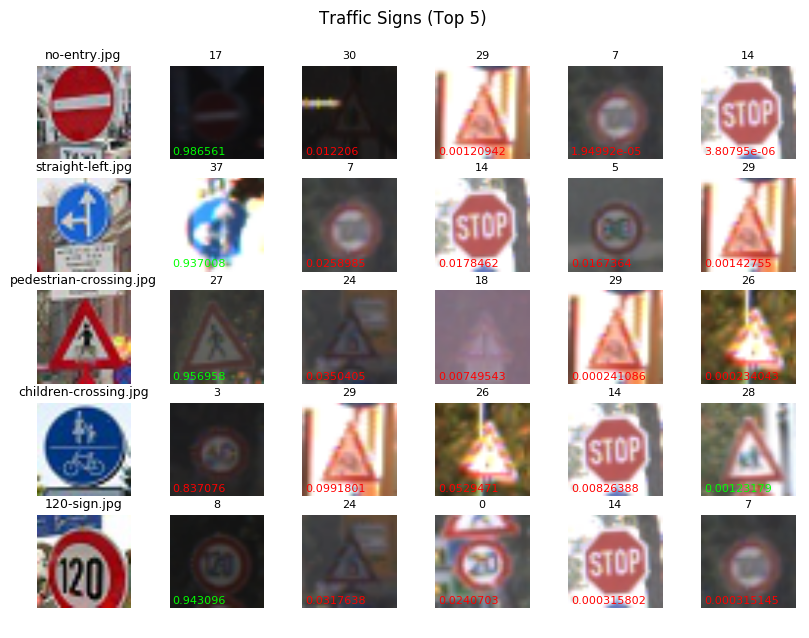

In [131]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

images = []
kv = 5

with tf.Session() as sess:
    topk = sess.run(tf.nn.top_k(tf.constant(softmax_output), k=kv))
    
    pred_probs = np.array(topk.values)
    pred_labels = np.array(topk.indices)
    
    num_rows = 5
    num_cols = 6

    fig = plt.figure(figsize=(10, 7))  # width, height in inches
    k = 1
    
    with open(training_file, mode='rb') as f:
        train_orig = pickle.load(f)
    
    X_orig, y_orig = train_orig['features'], train_orig['labels']
    
    for i in range(len(pred_files)):
        img = mpimg.imread(os.path.join(test_dir, pred_files[i]))
        sub = fig.add_subplot(num_rows, num_cols, k)
        sub.set_title(str(pred_files[i]), fontsize=9)
        sub.imshow(img)
        sub.axis("off")
        
        # now plot top k predicted images
        for m in range(kv):
            k += 1
            
            img_sub = X_orig[y_orig == pred_labels[i][m]][0]
            sub = fig.add_subplot(num_rows, num_cols, k)
            sub.imshow(img_sub)
            sub.set_title(str(pred_labels[i][m]), fontsize=8)
            
            color = "red"
            if (pred_labels[i][m] == actual_files[i]):
                color = "lime"
            
            sub.text(0.5, 30, str(np.round(pred_probs[i][m], 12)), fontsize=8, color=color)
            sub.axis('off')
        
        k += 1

fig.suptitle("Traffic Signs (Top 5)",fontsize=12)

**Answer:**
After visualisation of the Top 5 softmax probabilities, we can see that the model got 4 out of 5 correct and the 4th sample had both parts of the sign contained in the top 5 probabilities, which is excellent.

The predictions also had a steep dropoff after the first prediction which confirms the models certainty on its predictions.  The two part sign however didn't fair as well, with the correct responses at position 5 and 2, respectively.  I postulate that the reasoning for this is the shape of the sign, however given that it was able to detect these in the top 5 means that the model is reasoning about the black glyphs contained within the signs and not just the signs shape or colour.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

#### Reflection
I thoroughly enjoyed this project, it harnesses your ability to intuitively craft a decent machine learning model.  However if I was to complete this project again, I would change a few of the normalisation and data augmentation techniques.  The normalisation method I used is instance based, which has a requirement of storing the statistics of the original training set after augmentation which can lead to issues at test time.  Using a normalisation method which works on a per-sample basis without any prior statistics would solve the issue here.  Finally, the data augmentation could have been improved by including image scaling and skewing techniques as well.

Training was fairly intensive with dropout layers, at around 2.5 hrs per epoch over the entire training set.  Training time could have been improved by turning off dropout to overfit and then retraining with dropout turned on to reduce training time.

Overall the expressiveness of the DenseNet is extremely good and was worth every epoch.